## Import libraries

In [28]:
## Import libraries for machine learning and data processing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
## For random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
## Add libraries for SMOTE
from imblearn.over_sampling import SMOTE

## Load file

In [29]:
## import dataset
raw_feature_df_scaled = pd.read_csv('/Users/adityaponnada/Downloads/time_study_data/processed_features_v1.csv')
## Display the first few rows of the dataset
raw_feature_df_scaled.head()

,participant_id,outcome,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,...,time_of_day_Night,location_category_Home,location_category_Other,location_category_School,location_category_Transit,location_category_Work,wake_day_part_0.0,wake_day_part_1.0,wake_day_part_2.0,wake_day_part_3.0
0,certifiedembargobartender@timestudy_com,1,1,0.0,0.0,1,0.995567,0.0,0.000000,0.891772,...,0,0,0,0,1,0,1,0,0,0
1,certifiedembargobartender@timestudy_com,1,1,NaN,NaN,1,0.995567,0.0,0.000000,0.883542,...,0,0,0,0,1,0,1,0,0,0
2,certifiedembargobartender@timestudy_com,0,1,0.0,1.0,0,NaN,1.0,0.301667,0.852631,...,0,0,1,0,0,0,1,0,0,0
3,certifiedembargobartender@timestudy_com,1,1,0.0,1.0,1,0.995567,0.0,0.000000,0.844384,...,0,0,0,0,1,0,1,0,0,0
4,certifiedembargobartender@timestudy_com,1,1,NaN,NaN,0,0.995705,1.0,0.150000,0.831944,...,0,0,0,0,1,0,1,0,0,0


## Impute missing data

In [30]:
def impute_missing_with_median(df):
    """
    Impute missing values in all columns of a DataFrame using the median strategy within each participant_id group, except for 'participant_id' and 'outcome'.
    If a group has all missing values for a column, fallback to the global median for that column.
    Returns a new DataFrame with imputed values.
    """
    skip_cols = ['participant_id', 'outcome']
    cols_to_impute = [col for col in df.columns if col not in skip_cols]
    df_result = df.copy()
    global_medians = df[cols_to_impute].median()
    def impute_group(group):
        group_medians = group.median()
        fill_values = group_medians.fillna(global_medians)
        return group.fillna(fill_values)
    # Only apply groupby to columns to impute, avoiding the warning
    imputed = df[cols_to_impute].groupby(df['participant_id'], group_keys=False).apply(impute_group)
    df_result[cols_to_impute] = imputed
    return df_result

# Example usage:
raw_feature_df_scaled = impute_missing_with_median(raw_feature_df_scaled)

## Split training and testing data

In [31]:
def split_train_test_by_time(df, id_col='participant_id', frac_train=0.10):
    """
    Splits the DataFrame so that for each participant_id, the first frac_train (default 80%) of rows are in the training set,
    and the remaining (tailing) rows are in the test set. Assumes data is sorted by time/order within each participant.
    Returns: train_df, test_df
    """
    train_list = []
    test_list = []
    for pid, group in df.groupby(id_col):
        n = len(group)
        split_idx = int(np.floor(frac_train * n))
        train_part = group.iloc[:split_idx]
        test_part = group.iloc[split_idx:]
        train_list.append(train_part)
        test_list.append(test_part)
    train_df = pd.concat(train_list).reset_index(drop=True)
    test_df = pd.concat(test_list).reset_index(drop=True)
    return train_df, test_df

# Example usage:
train_df, test_df = split_train_test_by_time(raw_feature_df_scaled)

## Apply SMOTE to training data

In [32]:
def apply_smote(train_df, outcome_col='outcome', id_col='participant_id', random_state=42):
    """
    Applies SMOTE to the training data to handle class imbalance. Returns resampled X and y as DataFrames/Series.
    """
    from imblearn.over_sampling import SMOTE
    feature_cols = [col for col in train_df.columns if col not in [outcome_col, id_col]]
    X_train = train_df[feature_cols]
    y_train = train_df[outcome_col]
    smote = SMOTE(random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    X_resampled = pd.DataFrame(X_resampled, columns=feature_cols)
    y_resampled = pd.Series(y_resampled, name=outcome_col)
    print('Original training set class distribution:')
    print(y_train.value_counts())
    print('Resampled training set class distribution:')
    print(y_resampled.value_counts())
    return X_resampled, y_resampled

# Example usage:
X_train_resampled, y_train_resampled = apply_smote(train_df)

Original training set class distribution:
outcome
1    9373
0    1430
Name: count, dtype: int64
Resampled training set class distribution:
outcome
1    9373
0    9373
Name: count, dtype: int64


## Train an individualized RandomForest classifier

In [33]:
def train_rf_per_participant(train_df, outcome_col='outcome', id_col='participant_id', random_state=42):
    """
    Trains a RandomForestClassifier (with class_weight='balanced') for each participant_id on their own training data.
    Returns a dictionary: participant_id -> trained classifier.
    """
    from sklearn.ensemble import RandomForestClassifier
    clfs = {}
    participant_ids = train_df[id_col].unique()
    for pid in participant_ids:
        user_df = train_df[train_df[id_col] == pid]
        feature_cols = [col for col in user_df.columns if col not in [outcome_col, id_col]]
        X = user_df[feature_cols]
        y = user_df[outcome_col]
        clf = RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=10, random_state=random_state)
        clf.fit(X, y)
        clfs[pid] = clf
    return clfs

# Example usage:
participant_clfs = train_rf_per_participant(train_df)

## Test on individual data

In [34]:
def evaluate_rf_per_participant(participant_clfs, test_df, outcome_col='outcome', id_col='participant_id'):
    """
    Evaluates each participant's RandomForest model on their own test data.
    Returns a DataFrame with accuracy, AUC, precision, recall, and F1 for each participant_id.
    """
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    results = []
    for pid, clf in participant_clfs.items():
        user_df = test_df[test_df[id_col] == pid]
        if user_df.empty:
            continue
        feature_cols = [col for col in user_df.columns if col not in [outcome_col, id_col]]
        X = user_df[feature_cols]
        y = user_df[outcome_col]
        if len(y.unique()) < 2:
            # Metrics like AUC are undefined if only one class is present
            auc = float('nan')
        else:
            if hasattr(clf, 'predict_proba'):
                y_proba = clf.predict_proba(X)[:, 1]
                auc = roc_auc_score(y, y_proba)
            else:
                auc = float('nan')
        y_pred = clf.predict(X)
        acc = accuracy_score(y, y_pred)
        prec = precision_score(y, y_pred, zero_division=0)
        rec = recall_score(y, y_pred, zero_division=0)
        f1 = f1_score(y, y_pred, zero_division=0)
        results.append({
            'participant_id': pid,
            'accuracy': acc,
            'auc': auc,
            'precision': prec,
            'recall': rec,
            'f1': f1
        })
    return pd.DataFrame(results)

# Example usage:
participant_results = evaluate_rf_per_participant(participant_clfs, test_df)

## ROC curve for each model against baseline

/var/folders/h6/3rl340nn7cg92xvwk801_3b80000gn/T/ipykernel_21104/3762151928.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(participant_ids))


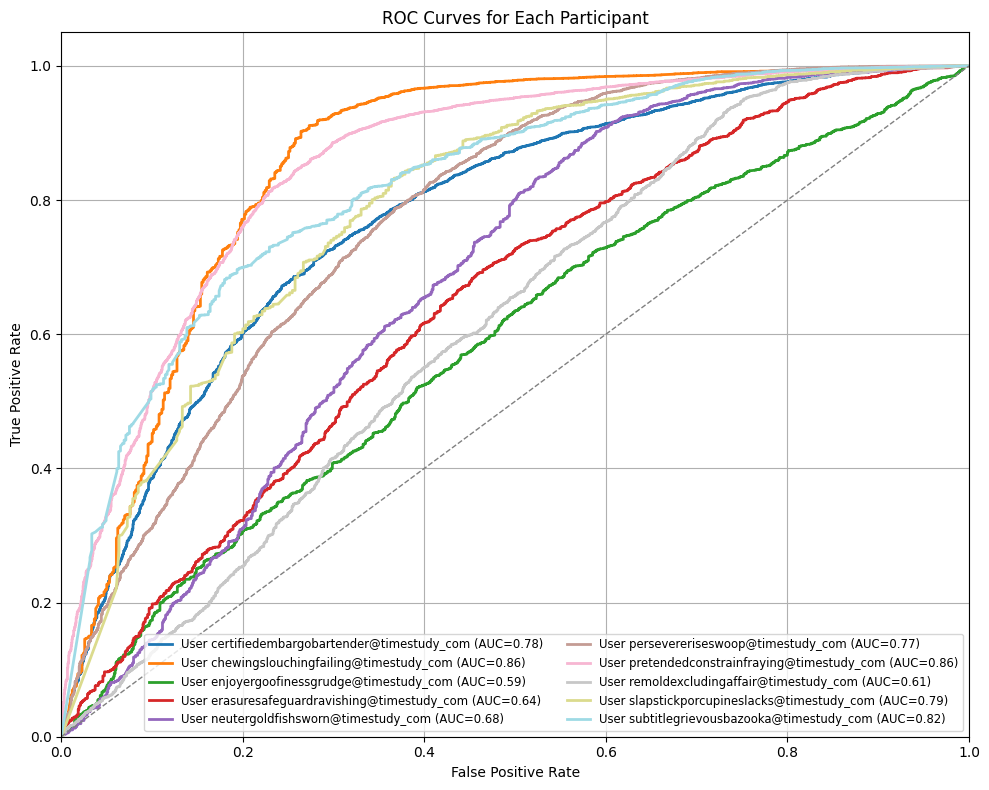

In [35]:
def plot_roc_curves_per_participant(participant_clfs, test_df, outcome_col='outcome', id_col='participant_id'):
    """
    Plots the ROC curve for each participant_id's model on their own test data, all in one plot with color-coded legend.
    """
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib.cm as cm
    participant_ids = list(participant_clfs.keys())
    colors = cm.get_cmap('tab20', len(participant_ids))
    plt.figure(figsize=(10, 8))
    for idx, pid in enumerate(participant_ids):
        clf = participant_clfs[pid]
        user_df = test_df[test_df[id_col] == pid]
        if user_df.empty:
            continue
        feature_cols = [col for col in user_df.columns if col not in [outcome_col, id_col]]
        X = user_df[feature_cols]
        y = user_df[outcome_col]
        if len(y.unique()) < 2:
            continue  # ROC undefined if only one class present
        if hasattr(clf, 'predict_proba'):
            y_proba = clf.predict_proba(X)[:, 1]
        else:
            continue
        fpr, tpr, _ = roc_curve(y, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors(idx), lw=2, label=f'User {pid} (AUC={roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Each Participant')
    plt.legend(loc='lower right', fontsize='small', ncol=2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_roc_curves_per_participant(participant_clfs, test_df)

## View metrics for all participants

In [36]:
def print_participant_metrics(metrics_df):
    """
    Prints the DataFrame of model metrics for all participants, with columns as metrics and rows as participants.
    """
    print(metrics_df.to_string(index=False))

# Example usage:
print_participant_metrics(participant_results)

                         participant_id  accuracy      auc  precision   recall       f1
certifiedembargobartender@timestudy_com  0.821442 0.776799   0.846547 0.950126 0.895351
  chewingslouchingfailing@timestudy_com  0.951568 0.859155   0.960471 0.989465 0.974753
   enjoyergoofinessgrudge@timestudy_com  0.883553 0.586999   0.883728 0.999760 0.938170
erasuresafeguardravishing@timestudy_com  0.692423 0.643987   0.754615 0.836627 0.793507
      neutergoldfishsworn@timestudy_com  0.894804 0.678542   0.908222 0.980640 0.943042
       persevereriseswoop@timestudy_com  0.846674 0.774480   0.853411 0.974987 0.910157
pretendedconstrainfraying@timestudy_com  0.879893 0.855822   0.905297 0.957407 0.930623
    remoldexcludingaffair@timestudy_com  0.756397 0.613171   0.777800 0.934936 0.849160
 slapstickporcupineslacks@timestudy_com  0.966971 0.793190   0.970565 0.996086 0.983160
  subtitlegrievousbazooka@timestudy_com  0.960327 0.823234   0.963016 0.996861 0.979646


## Visualize F1 distribution.

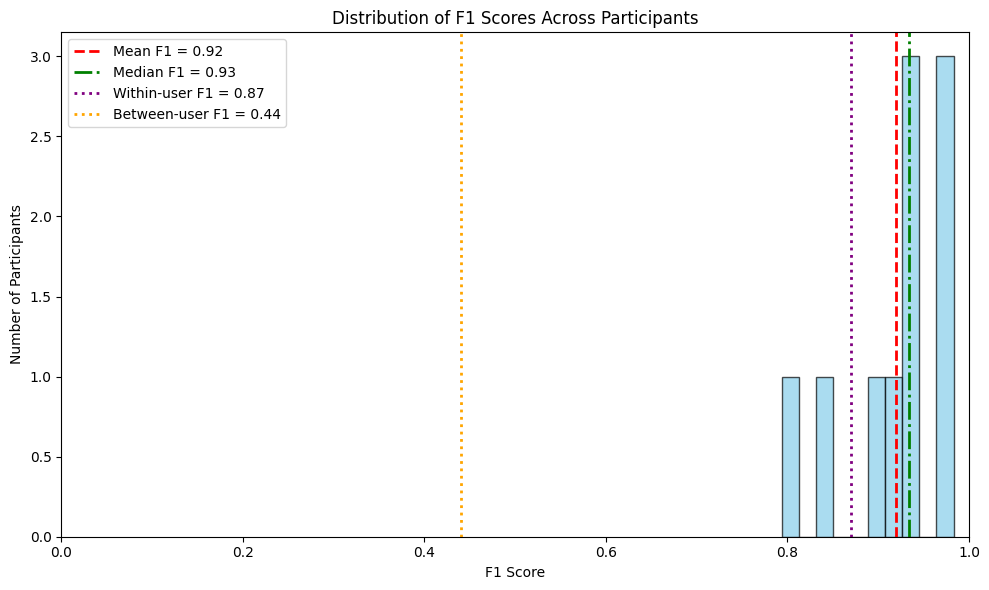

In [40]:
def plot_f1_distribution(metrics_df, within_user_f1=0.87, between_user_f1=0.44):
    """
    Plots a histogram of F1 scores across all participant_ids, with mean and median lines labeled, and two reference vertical lines for within-user and between-user training F1.
    """
    import matplotlib.pyplot as plt
    f1_scores = metrics_df['f1'].dropna()
    mean_f1 = f1_scores.mean()
    median_f1 = f1_scores.median()
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(f1_scores, bins=10, color='skyblue', edgecolor='black', alpha=0.7)
    # Mean and median lines
    ax.axvline(mean_f1, color='red', linestyle='--', linewidth=2, label=f'Mean F1 = {mean_f1:.2f}')
    ax.axvline(median_f1, color='green', linestyle='-.', linewidth=2, label=f'Median F1 = {median_f1:.2f}')
    # Reference lines
    ax.axvline(within_user_f1, color='purple', linestyle=':', linewidth=2, label='Within-user F1 = 0.87')
    ax.axvline(between_user_f1, color='orange', linestyle=':', linewidth=2, label='Between-user F1 = 0.44')
    ax.set_xlabel('F1 Score')
    ax.set_ylabel('Number of Participants')
    ax.set_title('Distribution of F1 Scores Across Participants')
    ax.set_xlim(0, 1)
    ax.legend()
    plt.tight_layout()
    plt.show()
    return fig

# Example usage:
f1_hist_fig = plot_f1_distribution(participant_results)

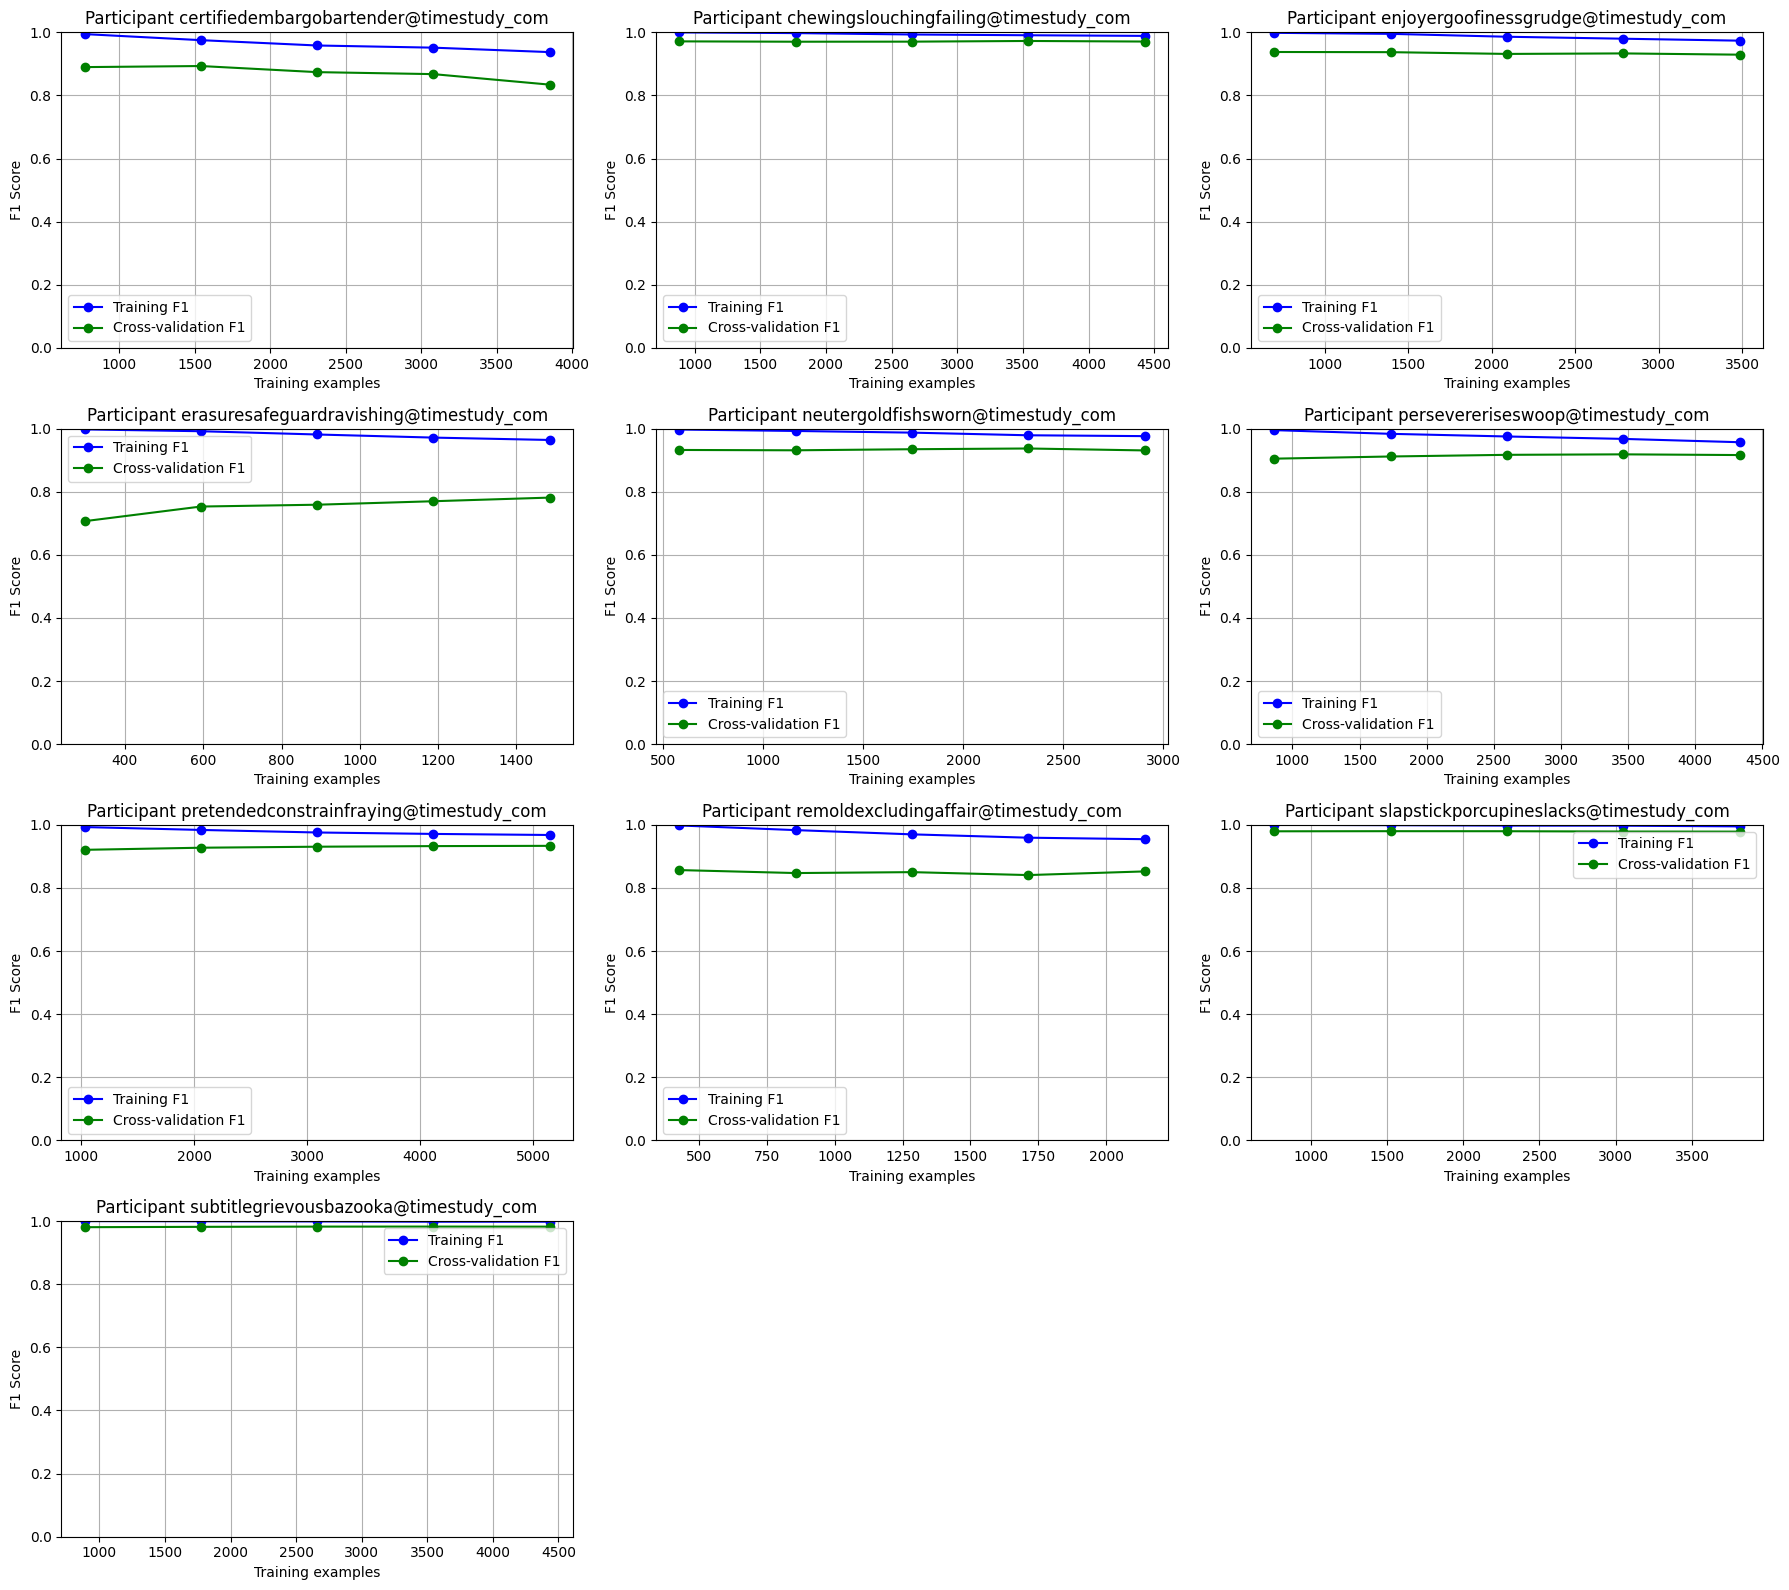

In [25]:
def plot_learning_curves_per_participant(train_df, outcome_col='outcome', id_col='participant_id', random_state=42):
    """
    Plots the learning curve (F1 score) for each participant_id using their own training data.
    """
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import learning_curve
    import matplotlib.pyplot as plt
    import numpy as np
    participant_ids = train_df[id_col].unique()
    n_participants = len(participant_ids)
    ncols = 3
    nrows = int(np.ceil(n_participants / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows), squeeze=False)
    for idx, pid in enumerate(participant_ids):
        user_df = train_df[train_df[id_col] == pid]
        feature_cols = [col for col in user_df.columns if col not in [outcome_col, id_col]]
        X = user_df[feature_cols]
        y = user_df[outcome_col]
        if len(np.unique(y)) < 2:
            continue  # skip if only one class
        clf = RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=10, random_state=random_state)
        train_sizes, train_scores, test_scores = learning_curve(
            clf, X, y, cv=3, scoring='f1', train_sizes=np.linspace(0.2, 1.0, 5), random_state=random_state)
        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        ax = axes[idx // ncols, idx % ncols]
        ax.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training F1')
        ax.plot(train_sizes, test_scores_mean, 'o-', color='green', label='Cross-validation F1')
        ax.set_title(f'Participant {pid}')
        ax.set_xlabel('Training examples')
        ax.set_ylabel('F1 Score')
        ax.set_ylim(0, 1)
        ax.legend()
        ax.grid(True)
    # Hide any unused subplots
    for j in range(idx+1, nrows*ncols):
        fig.delaxes(axes[j // ncols, j % ncols])
    plt.tight_layout()
    plt.show()

# Example usage:
plot_learning_curves_per_participant(train_df)

In [41]:
# Print the number of training samples in train_df for all participants
participant_counts = train_df['participant_id'].value_counts().sort_index()
print('Number of training samples per participant:')
print(participant_counts)

Number of training samples per participant:
participant_id
certifiedembargobartender@timestudy_com    1155
chewingslouchingfailing@timestudy_com      1328
enjoyergoofinessgrudge@timestudy_com       1045
erasuresafeguardravishing@timestudy_com     445
neutergoldfishsworn@timestudy_com           872
persevereriseswoop@timestudy_com           1299
pretendedconstrainfraying@timestudy_com    1544
remoldexcludingaffair@timestudy_com         642
slapstickporcupineslacks@timestudy_com     1143
subtitlegrievousbazooka@timestudy_com      1330
Name: count, dtype: int64


In [39]:
# Compute and print mean and standard deviation of all metrics
if 'participant_results' in locals():
    metrics_mean = participant_results.mean(numeric_only=True)
    metrics_std = participant_results.std(numeric_only=True)
    print('Mean of metrics:')
    print(metrics_mean)
    print('\nStandard deviation of metrics:')
    print(metrics_std)
else:
    print('participant_results DataFrame not found. Please run the evaluation step first.')

Mean of metrics:
accuracy     0.865405
auc          0.740538
precision    0.882367
recall       0.961689
f1           0.919757
dtype: float64

Standard deviation of metrics:
accuracy     0.089593
auc          0.101325
precision    0.075245
recall       0.049087
f1           0.060774
dtype: float64


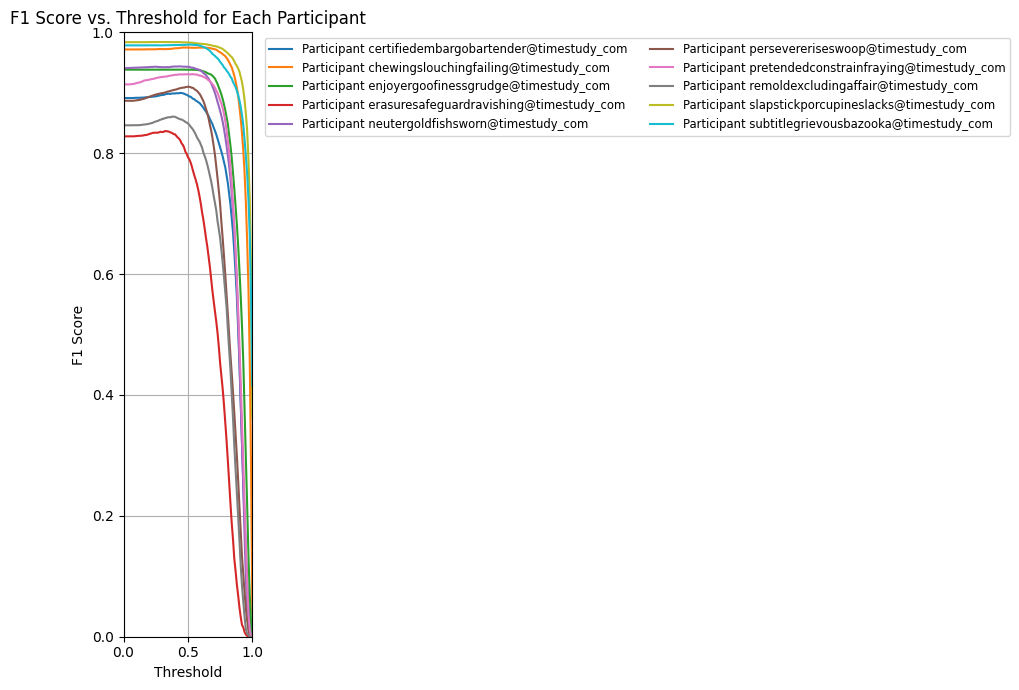

In [42]:
def plot_f1_vs_threshold_per_participant(participant_clfs, test_df, outcome_col='outcome', id_col='participant_id'):
    """
    Plots F1 score vs. threshold for each participant_id's model on their own test data, all on one plot.
    Each line represents a participant_id.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import f1_score
    thresholds = np.linspace(0, 1, 101)
    plt.figure(figsize=(10, 7))
    for pid, clf in participant_clfs.items():
        user_df = test_df[test_df[id_col] == pid]
        if user_df.empty:
            continue
        feature_cols = [col for col in user_df.columns if col not in [outcome_col, id_col]]
        X = user_df[feature_cols]
        y_true = user_df[outcome_col]
        if len(np.unique(y_true)) < 2 or not hasattr(clf, 'predict_proba'):
            continue
        y_proba = clf.predict_proba(X)[:, 1]
        f1s = []
        for thresh in thresholds:
            y_pred = (y_proba >= thresh).astype(int)
            f1 = f1_score(y_true, y_pred, zero_division=0)
            f1s.append(f1)
        plt.plot(thresholds, f1s, label=f'Participant {pid}')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs. Threshold for Each Participant')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend(fontsize='small', ncol=2, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_f1_vs_threshold_per_participant(participant_clfs, test_df)